In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

#Take off display limitations on Pandas
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

#supplementary data
holidays = pd.read_csv('holidays_events.csv')
stores = pd.read_csv('stores.csv')
oil = pd.read_csv('oil.csv')
transactions = pd.read_csv('transactions.csv')

In [2]:
#Convert the dat feature d-type to 'datetime' this is important to use in TS forecasting
train_df['date']=pd.to_datetime(train_df['date'])
test_df['date']=pd.to_datetime(test_df['date'])
holidays['date']=pd.to_datetime(holidays['date'])
transactions['date']=pd.to_datetime(transactions['date'])
oil['date']=pd.to_datetime(oil['date'])

In [3]:
oil.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        1218 non-null   datetime64[ns]
 1   dcoilwtico  1175 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 19.2 KB


In [4]:
#set the date as an index and this will help with EDA when we plot
oil.set_index('date', inplace=True)

# Create a new DataFrame with complete date range
date_range = pd.date_range(start=oil.index.min(), end=oil.index.max(), freq='D')
complete_oil = pd.DataFrame(index=date_range)

# Merge the original oil data with the complete date range DataFrame
complete_oil = complete_oil.merge(oil, left_index=True, right_index=True, how='left')

# Forward fill missing values to carry forward the last known value
complete_oil['dcoilwtico'].fillna(method='ffill', inplace=True)
complete_oil['dcoilwtico'].fillna(method='bfill', inplace=True)#fill the first date

In [5]:
# Reset index
complete_oil.reset_index(inplace=True)
complete_oil.rename(columns={'index': 'date'}, inplace=True)

In [6]:
#Get feature names and store them for future ease of use
train_columns = train_df.columns
test_columns = test_df.columns
stores_columns = stores.columns
oil_columns = oil.columns
holidays_columns = holidays.columns
transactions_columns = transactions.columns

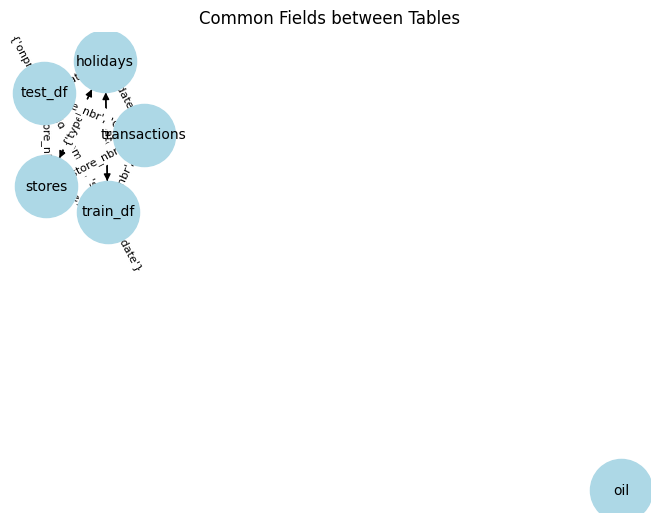

In [6]:
#plot the links between each set and use this information to merge them

tables = {
    'train_df': train_columns,
     'test_df': test_df.columns,  # Add other fields
    'stores': stores.columns,  # Add other fields
    'oil': oil.columns,  # Add other fields
    'holidays': holidays.columns,  # Add other fields
    'transactions':transactions.columns
}
# Create a directed graph
G = nx.DiGraph()

# Add nodes (tables)
for table in tables:
    G.add_node(table)

# Add edges (common fields)
for table1 in tables:
    for table2 in tables:
        if table1 != table2:
            common_fields = set(tables[table1]) & set(tables[table2])
            if common_fields:
                G.add_edge(table1, table2, common_fields=common_fields)

# Plot the graph
pos = nx.spring_layout(G)  # Layout for better visualization
nx.draw(G, pos, with_labels=True, node_size=2000, font_size=10, node_color='lightblue')
edge_labels = nx.get_edge_attributes(G, 'common_fields')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)
plt.title("Common Fields between Tables")
plt.show()

In [7]:
complete_oil.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1704 entries, 0 to 1703
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        1704 non-null   datetime64[ns]
 1   dcoilwtico  1704 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 26.8 KB


In [8]:
#merge the datasets into one big one for Train and Test
frames = [train_df, complete_oil]

train = pd.merge(train_df, stores, on='store_nbr', how='left')
train = pd.concat(frames, axis=1)
train = pd.merge(train_df, holidays, on='date', how='left')

test = pd.merge(test_df, stores, on='store_nbr', how='left')
test = pd.concat(frames, axis=1)
test = pd.merge(test_df, holidays, on='date', how='left')

In [11]:
test.head()

,id,date,store_nbr,family,onpromotion,type,locale,locale_name,description,transferred
0,3000888,2017-08-16,1,AUTOMOTIVE,0,NaN,NaN,NaN,NaN,NaN
1,3000889,2017-08-16,1,BABY CARE,0,NaN,NaN,NaN,NaN,NaN
2,3000890,2017-08-16,1,BEAUTY,2,NaN,NaN,NaN,NaN,NaN
3,3000891,2017-08-16,1,BEVERAGES,20,NaN,NaN,NaN,NaN,NaN
4,3000892,2017-08-16,1,BOOKS,0,NaN,NaN,NaN,NaN,NaN


In [9]:
#Since .info() doesnt show enough data on the missing data we need to do it
#differently
# Count the number of missing values in each column

train_missing_values = train.isnull().sum()
test_missing_values = test.isnull().sum()

print("Missing Values in Train DataFrame:")
print(train_missing_values)
print("\nMissing Values in Test DataFrame:")
print(test_missing_values)

Missing Values in Train DataFrame:
id                   0
date                 0
store_nbr            0
family               0
sales                0
onpromotion          0
type           2551824
locale         2551824
locale_name    2551824
description    2551824
transferred    2551824
dtype: int64

Missing Values in Test DataFrame:
id                 0
date               0
store_nbr          0
family             0
onpromotion        0
type           26730
locale         26730
locale_name    26730
description    26730
transferred    26730
dtype: int64


In [10]:
from sklearn.preprocessing import LabelEncoder
#Select the 'Object' features and then do feature encoding
non_numeric_columns = train.select_dtypes(exclude=['number']).columns.tolist()
non_numeric_columns=non_numeric_columns[1:]

label_encoder = LabelEncoder()
# Convert non-numeric columns to numeric labels
for col in non_numeric_columns:
    train[col] = label_encoder.fit_transform(train[col])
    test[col] = label_encoder.transform(test[col])

In [11]:
#check if the job is done
train_missing_values = train.isnull().sum()
test_missing_values = test.isnull().sum()

print("Missing Values in Train DataFrame:")
print(train_missing_values)
print("\nMissing Values in Test DataFrame:")
print(test_missing_values)

Missing Values in Train DataFrame:
id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
type           0
locale         0
locale_name    0
description    0
transferred    0
dtype: int64

Missing Values in Test DataFrame:
id             0
date           0
store_nbr      0
family         0
onpromotion    0
type           0
locale         0
locale_name    0
description    0
transferred    0
dtype: int64


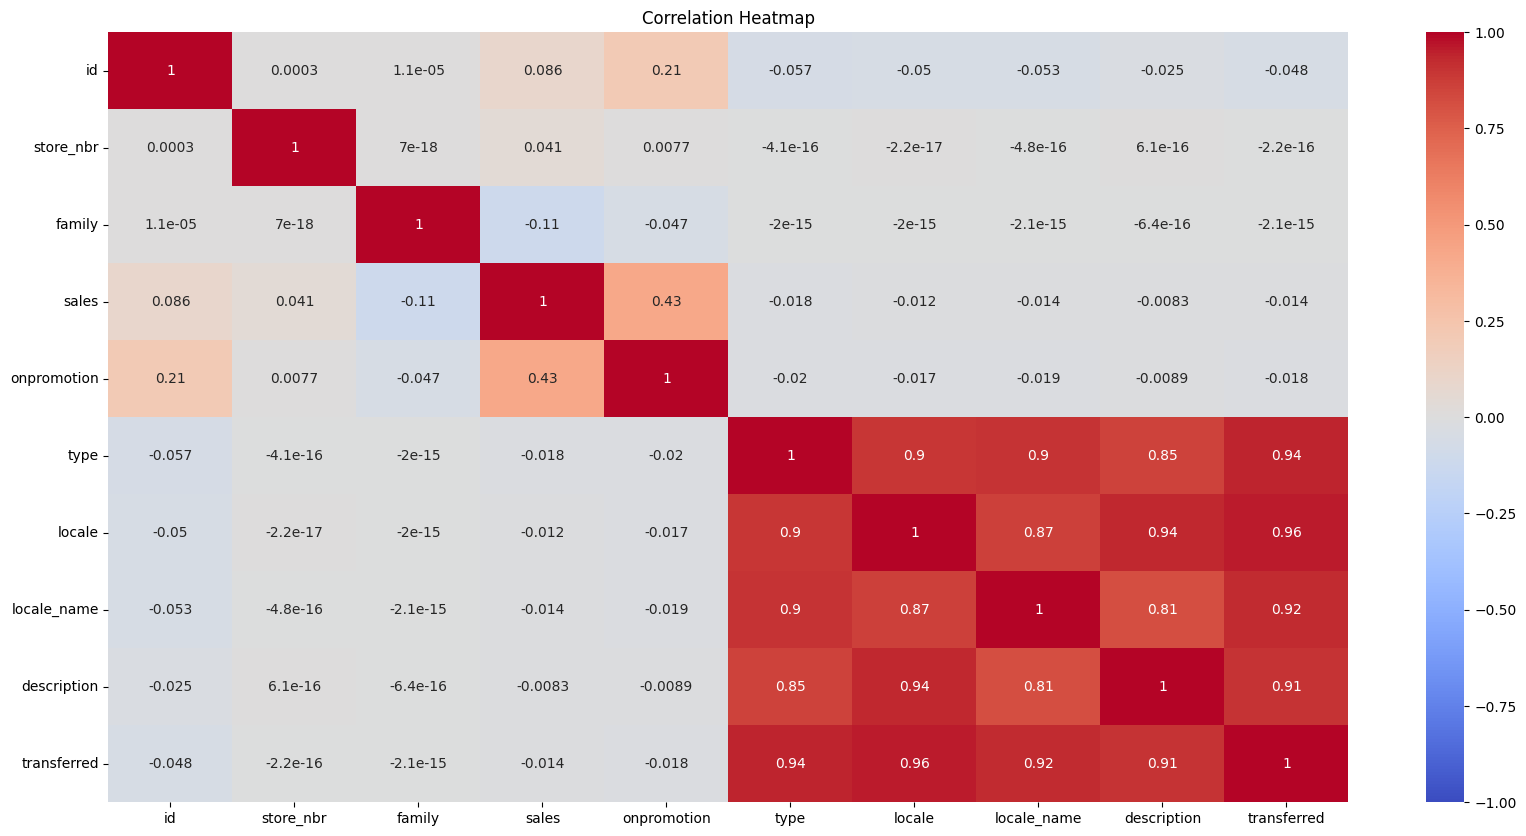

In [13]:
#Since all the data has been cleaned and converted for modelling
#we should look at correlation and decide which features are relevant
train_to_see_corr = train.drop(['date'], axis=1, errors="ignore")
correlation_matrix = train_to_see_corr.corr()
correlation_with_target = correlation_matrix['sales'].sort_values(ascending=False)
# Plot heatmap
plt.figure(figsize=(20, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()

In [12]:
#split the date into specific features from that date

def create_features(data):
    data=data.copy()
    data['date']=pd.to_datetime(data['date'])                                                  
    data['dayofweek']=data['date'].dt.dayofweek
    data['quarter']=data['date'].dt.quarter
    data['day']=data['date'].dt.day
    data['month']=data['date'].dt.month
    data['year']=data['date'].dt.year
        
    
    return data

In [13]:
#run the train and test set through the function
train=create_features(train)
test=create_features(test)

In [14]:
train.head()

,id,date,store_nbr,family,sales,onpromotion,type,locale,locale_name,description,transferred,dayofweek,quarter,day,month,year
0,0,2013-01-01,1,0,0.0,0,3,1,4,50,0,1,1,1,1,2013
1,1,2013-01-01,1,1,0.0,0,3,1,4,50,0,1,1,1,1,2013
2,2,2013-01-01,1,2,0.0,0,3,1,4,50,0,1,1,1,1,2013
3,3,2013-01-01,1,3,0.0,0,3,1,4,50,0,1,1,1,1,2013
4,4,2013-01-01,1,4,0.0,0,3,1,4,50,0,1,1,1,1,2013


In [16]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV

#define a score function for each training split
def rmsle_score(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

rmsle_scorer = make_scorer(rmsle_score, greater_is_better=False)

In [17]:
model_features = ['id', 'store_nbr', 'family', 'onpromotion', 'type', 'locale', 'locale_name',
                  'description', 'transferred', 'dayofweek', 'quarter', 'day', 'month', 'year']

In [18]:
# get different "family" value
family_values = train["family"].unique()

# initialize dict for each model and score
family_models = {}
family_scores={}

# 3. train for each "family" model
for family_value in family_values:
    family_data = train[train["family"] == family_value]
    
    # split
    X = family_data[model_features].drop(columns=['family'])  
    y = family_data["sales"]  
    
    
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)
    
    
    model = XGBRegressor(random_state=42)
    model.fit(X_train, y_train)
    
    # save model
    family_models[family_value] = model
    
     # predict the x_valide
    y_pred = model.predict(X_valid)
    y_pred = np.maximum(y_pred, 0)#less than 0 become 0
    
    # calculate RMSLE
    rmsle = np.sqrt(mean_squared_log_error(y_valid, y_pred))
    family_scores[family_value] = rmsle

    # output each "family"  RMSLE score
    print(f"Family: {family_value}, RMSLE: {rmsle}")

Family: 0, RMSLE: 0.5670635957015688
Family: 1, RMSLE: 0.20706053827799237
Family: 2, RMSLE: 0.5037477800907328
Family: 3, RMSLE: 1.1288306711684306
Family: 4, RMSLE: 0.13042040642734096
Family: 5, RMSLE: 0.8670169133536818
Family: 6, RMSLE: 0.5853508898514739
Family: 7, RMSLE: 1.0052779482331122
Family: 8, RMSLE: 0.8800907205311462
Family: 9, RMSLE: 0.7077868263109188
Family: 10, RMSLE: 0.7347416462681574
Family: 11, RMSLE: 0.7926719055598517
Family: 12, RMSLE: 1.2027614403265992
Family: 13, RMSLE: 0.6541023398324497
Family: 14, RMSLE: 0.5306921500594715
Family: 15, RMSLE: 0.7683232583926171
Family: 16, RMSLE: 0.6177929411800352
Family: 17, RMSLE: 0.36790203571034874
Family: 18, RMSLE: 1.2291901705455202
Family: 19, RMSLE: 0.6469341827165388
Family: 20, RMSLE: 0.5713726807965499
Family: 21, RMSLE: 0.673801311218905
Family: 22, RMSLE: 1.0341251029143692
Family: 23, RMSLE: 0.4458615042364503
Family: 24, RMSLE: 0.8295768277736567
Family: 25, RMSLE: 0.7566724265909684
Family: 26, RMSLE: 0

In [19]:
average_rmsle = np.mean(list(family_scores.values()))
print(f"Average RMSLE for all families: {average_rmsle}")

Average RMSLE for all families: 0.7201307405637535


In [20]:
# initialize an empty dictionary to store the avg sales values for
#different family values
family_mean_sales = {}

for family_value in family_values:
    family_data = train[train["family"] == family_value]
    mean_sales = family_data["sales"].mean()
    family_mean_sales[family_value] = mean_sales

In [ ]:
#store the features that will be used
test_dataset = test[model_features]

In [24]:
#Create the Dataframe for the submission
predictions = pd.DataFrame()

#initialize an empty list to store the values
test_predictions = []

#get the DISTINCT products for the values to be predicted for each, in total there are 5
test_family_values = test['family'].unique()

#create a loop for the model to go through each product and do its prediction
#if there is a value then it will work with it, or else it will assign a default value based on the training split before
for test_family_value in test_family_values:
    test_family_data = test[test['family'] == test_family_value]
    X_test = test_family_data[model_features].drop(['family'], axis=1, errors="ignore")
    model = family_models.get(test_family_value)
    if model is not None:
        prediction = model.predict(X_test)
        prediction = np.maximum(prediction, 0)
        test_family_data = test_family_data.copy()
        test_family_data.loc[:, 'sales'] = prediction
        predictions = pd.concat([predictions, test_family_data], ignore_index=True)
        test_predictions.append(prediction)
    else:
        default_prediction = family_mean_sales.get(family_value, DEFAULT_PREDICTION)
        test_family_data.loc[:, 'sales'] = default_prediction
        predictions = pd.concat([predictions, test_family_data], ignore_index=True)
        test_predictions.append(default_prediction)

In [25]:
#structure the CSV file to be submitted
predictions = predictions[['id', 'sales']]
predictions = predictions.sort_values(by='id')

In [26]:
predictions.head()

,id,sales
0,3000888,3.982965
864,3000889,0.000000
1728,3000890,3.925443
2592,3000891,2320.461670
3456,3000892,0.062894


In [27]:
predictions.to_csv('predictions.csv', index=False)
#DONE!